# Проект: классификация

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [262]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Данные о клиентах банка:<br>

age (возраст);<br>
job (сфера занятости);<br>
marital (семейное положение);<br>
education (уровень образования);<br>
default (имеется ли просроченный кредит);<br>
housing (имеется ли кредит на жильё);<br>
loan (имеется ли кредит на личные нужды);<br>
balance (баланс).<br>
Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:<br>

contact (тип контакта с клиентом);<br>
month (месяц, в котором был последний контакт);<br>
day (день, в который был последний контакт);<br>
duration (продолжительность контакта в секундах).<br>
Прочие признаки:<br>

campaign (количество контактов с этим клиентом в течение текущей кампании);<br>
pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);<br>
previous (количество контактов до текущей кампании)<br>
poutcome (результат прошлой маркетинговой кампании).<br>
И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.<br>

In [263]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [264]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [265]:
df['balance'].head()

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

In [266]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: str(x).replace(',', '.'))
df['balance'] = df['balance'].apply(lambda x: str(x).replace(' ', ''))
df['balance'] = df['balance'].apply(lambda x: str(x).replace('$', ''))
df['balance'] = df['balance'].astype(float)
df['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

In [267]:
# заменим пропуски в balance на медиану
df['balance'].fillna(df['balance'].median(), inplace=True)
df['balance'].describe()

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

In [268]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [269]:
mask = df['job'] == 'unknown'
df.loc[mask, 'job'] = df['job'].mode()[0]

In [270]:
mask = df['education'] == 'unknown'
df.loc[mask, 'education'] = df['education'].mode()[0]
df['education'].value_counts()

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

In [271]:
mask = ((df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0]))

df['balance'][mask].mean()

1598.8829787234042

In [272]:
# найдём межквартильный размах balance
q1 = df['balance'].quantile(0.25)
q3 = df['balance'].quantile(0.75)
iqr = q3 - q1
iqr


1576.0

In [273]:
q1 - 1.5 * iqr

-2241.0

In [274]:
q3 + 1.5 * iqr

4063.0

In [275]:
mask1 = df['balance'] > (q3 + 1.5 * iqr)
mask2 = df['balance'] < (q1 - 1.5 * iqr)
mask = mask1 | mask2   # маска для выбросов
df.shape[0] - df[mask].shape[0]


10105

In [276]:
# удалим выбросы
df = df[~mask]
df.shape

(10105, 17)

In [277]:
# посчитаем, сколько клиентов открыли депозит
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

In [278]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [279]:
df.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


In [280]:
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

In [281]:
months = df['month'].value_counts().index
neud_list = []
for month in months:
    neud_list.append((month, df[df['month'] == month]['deposit'].value_counts(normalize=True)['no']))
    
# FILEPATH: c:\IDE\Skillfactory\Project-4\Project_4_ML.ipynb
neud_list.sort(key=lambda x: x[1])

neud_list

[('dec', 0.0967741935483871),
 ('mar', 0.10126582278481013),
 ('sep', 0.16546762589928057),
 ('oct', 0.18507462686567164),
 ('apr', 0.3819277108433735),
 ('feb', 0.45557122708039494),
 ('jun', 0.5489130434782609),
 ('aug', 0.5595667870036101),
 ('nov', 0.5846153846153846),
 ('jul', 0.5895627644569816),
 ('jan', 0.6081504702194357),
 ('may', 0.6786396637371036)]

In [282]:
# создадим новый признак - принадлежность к возрастной категории
df['age_cat'] = df['age'].apply(lambda x: 'young' if x < 30
                               else 'middle' if x < 40
                               else 'adult' if x < 50
                               else 'aged' if x < 60
                               else 'old')

<AxesSubplot: xlabel='age_cat', ylabel='count'>

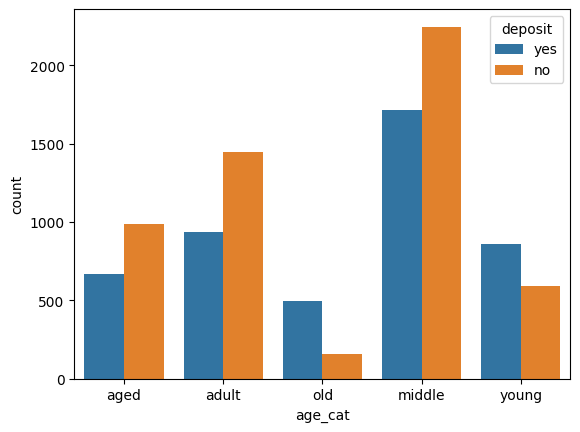

In [283]:
# построим диаграмму, отражающую соотношение клиентов, открывших депозит, в зависимости от возрастной категории
sns.countplot(x='age_cat', hue='deposit', data=df)


<AxesSubplot: xlabel='marital', ylabel='count'>

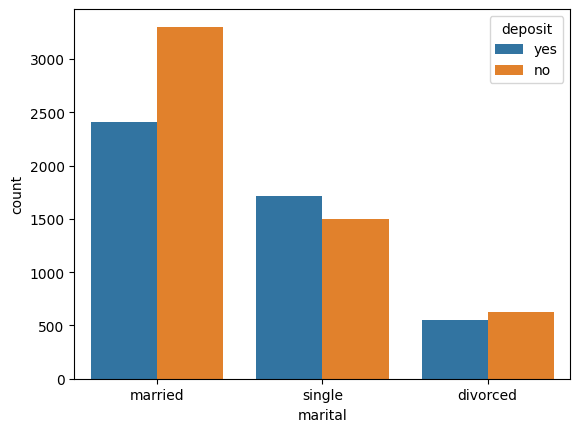

In [284]:
# построим диаграмму, отражающую соотношение клиентов, открывших депозит, в зависимости от семейного положения
sns.countplot(x='marital', hue='deposit', data=df)

<AxesSubplot: xlabel='education', ylabel='count'>

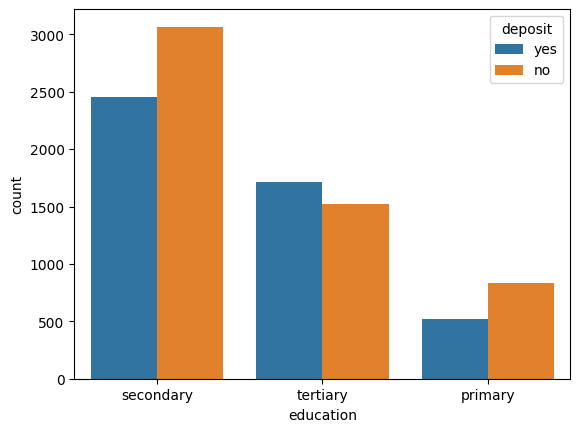

In [285]:
# построим диаграмму, отражающую соотношение клиентов, открывших депозит, в зависимости от образования
sns.countplot(x='education', hue='deposit', data=df)

<AxesSubplot: xlabel='job', ylabel='count'>

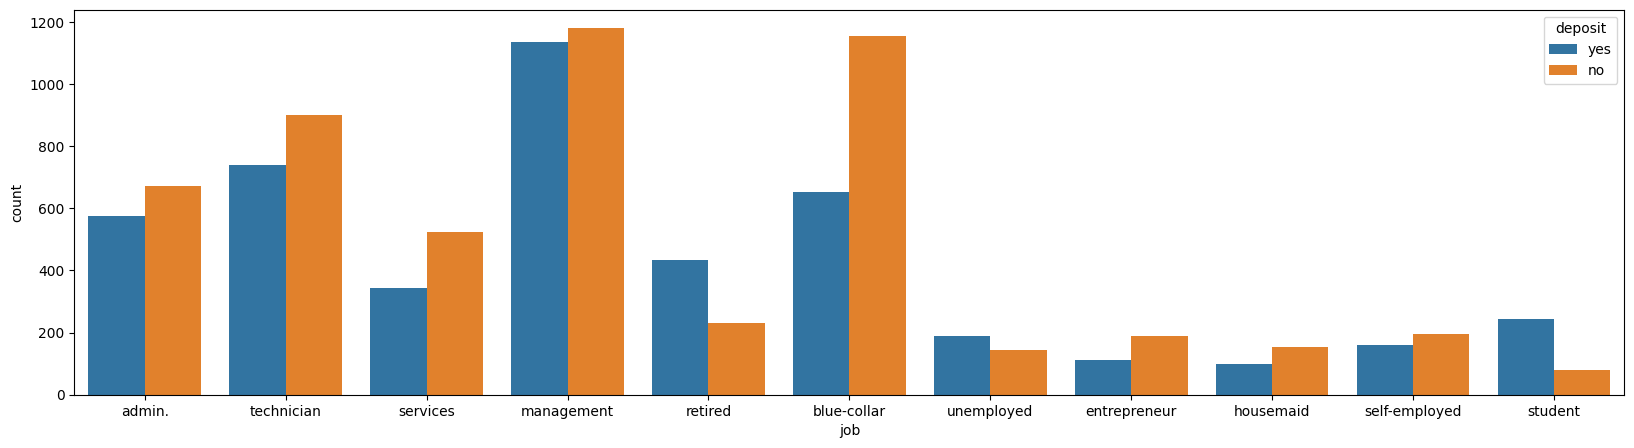

In [286]:
# построим диаграмму, отражающую соотношение клиентов, открывших депозит, в зависимости от типа работы. Сделам широкую диаграмму, что-бы было лучше видно
plt.figure(figsize=(20, 5))
sns.countplot(x='job', hue='deposit', data=df,  )

In [287]:
# разделим таблицу на две части, тех, кто открыл депозит и тех, кто не открыл
df_yes = df[df['deposit'] == 'yes']
df_no = df[df['deposit'] == 'no']

<AxesSubplot: xlabel='education', ylabel='marital'>

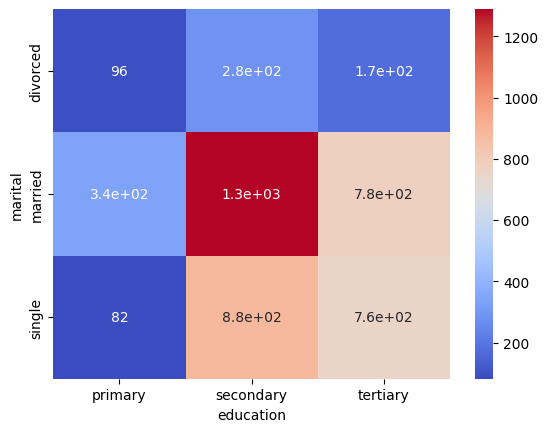

In [288]:
# построим сводную таблицу, отражающую соотношение клиентов, открывших депозит, в зависимости от типа образования и семейного положения
pd.crosstab(df_yes['marital'], df_yes['education'])

# построим тепловую карту
sns.heatmap(pd.crosstab(df_yes['marital'], df_yes['education']), annot=True, cmap='coolwarm')

<AxesSubplot: xlabel='education', ylabel='marital'>

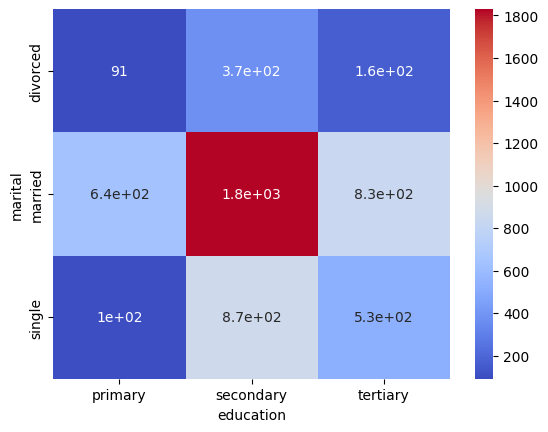

In [289]:
# построим тепловую карту для тех, кто не открыл депозит
sns.heatmap(pd.crosstab(df_no['marital'], df_no['education']), annot=True, cmap='coolwarm')

### Задание 4

In [290]:
# обработаем признак education c помощью LabelEncoder
le = LabelEncoder()
le.fit(df['education'])
df['education'] = le.transform(df['education'])


In [291]:
df['education'].sum()

11995

In [292]:
# обработаем признак age_cat c помощью LabelEncoder
le = LabelEncoder()
le.fit(df['age_cat'])
df['age_cat'] = le.transform(df['age_cat'])


In [293]:
# перекодируем признак deposit, что-бы вместо yes была 1, а вместо no - 0
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)


In [294]:
df['deposit'].std()

0.4986712532452124

In [295]:
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)


In [296]:
round(df['default'].mean() + df['housing'].mean() + df['loan'].mean() , 3)

0.635

In [297]:
# создадим dummy-переменные для признаков job, , marital, contact, month, poutcome
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=True)
#df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])


In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_cat            10105 non-null  int32  
 13  job_blue-collar    10105 non-null  uint8  
 14  job_entrepreneur   10105 non-null  uint8  
 15  job_housemaid      10105 non-null  uint8  
 16  job_management     101

<AxesSubplot: >

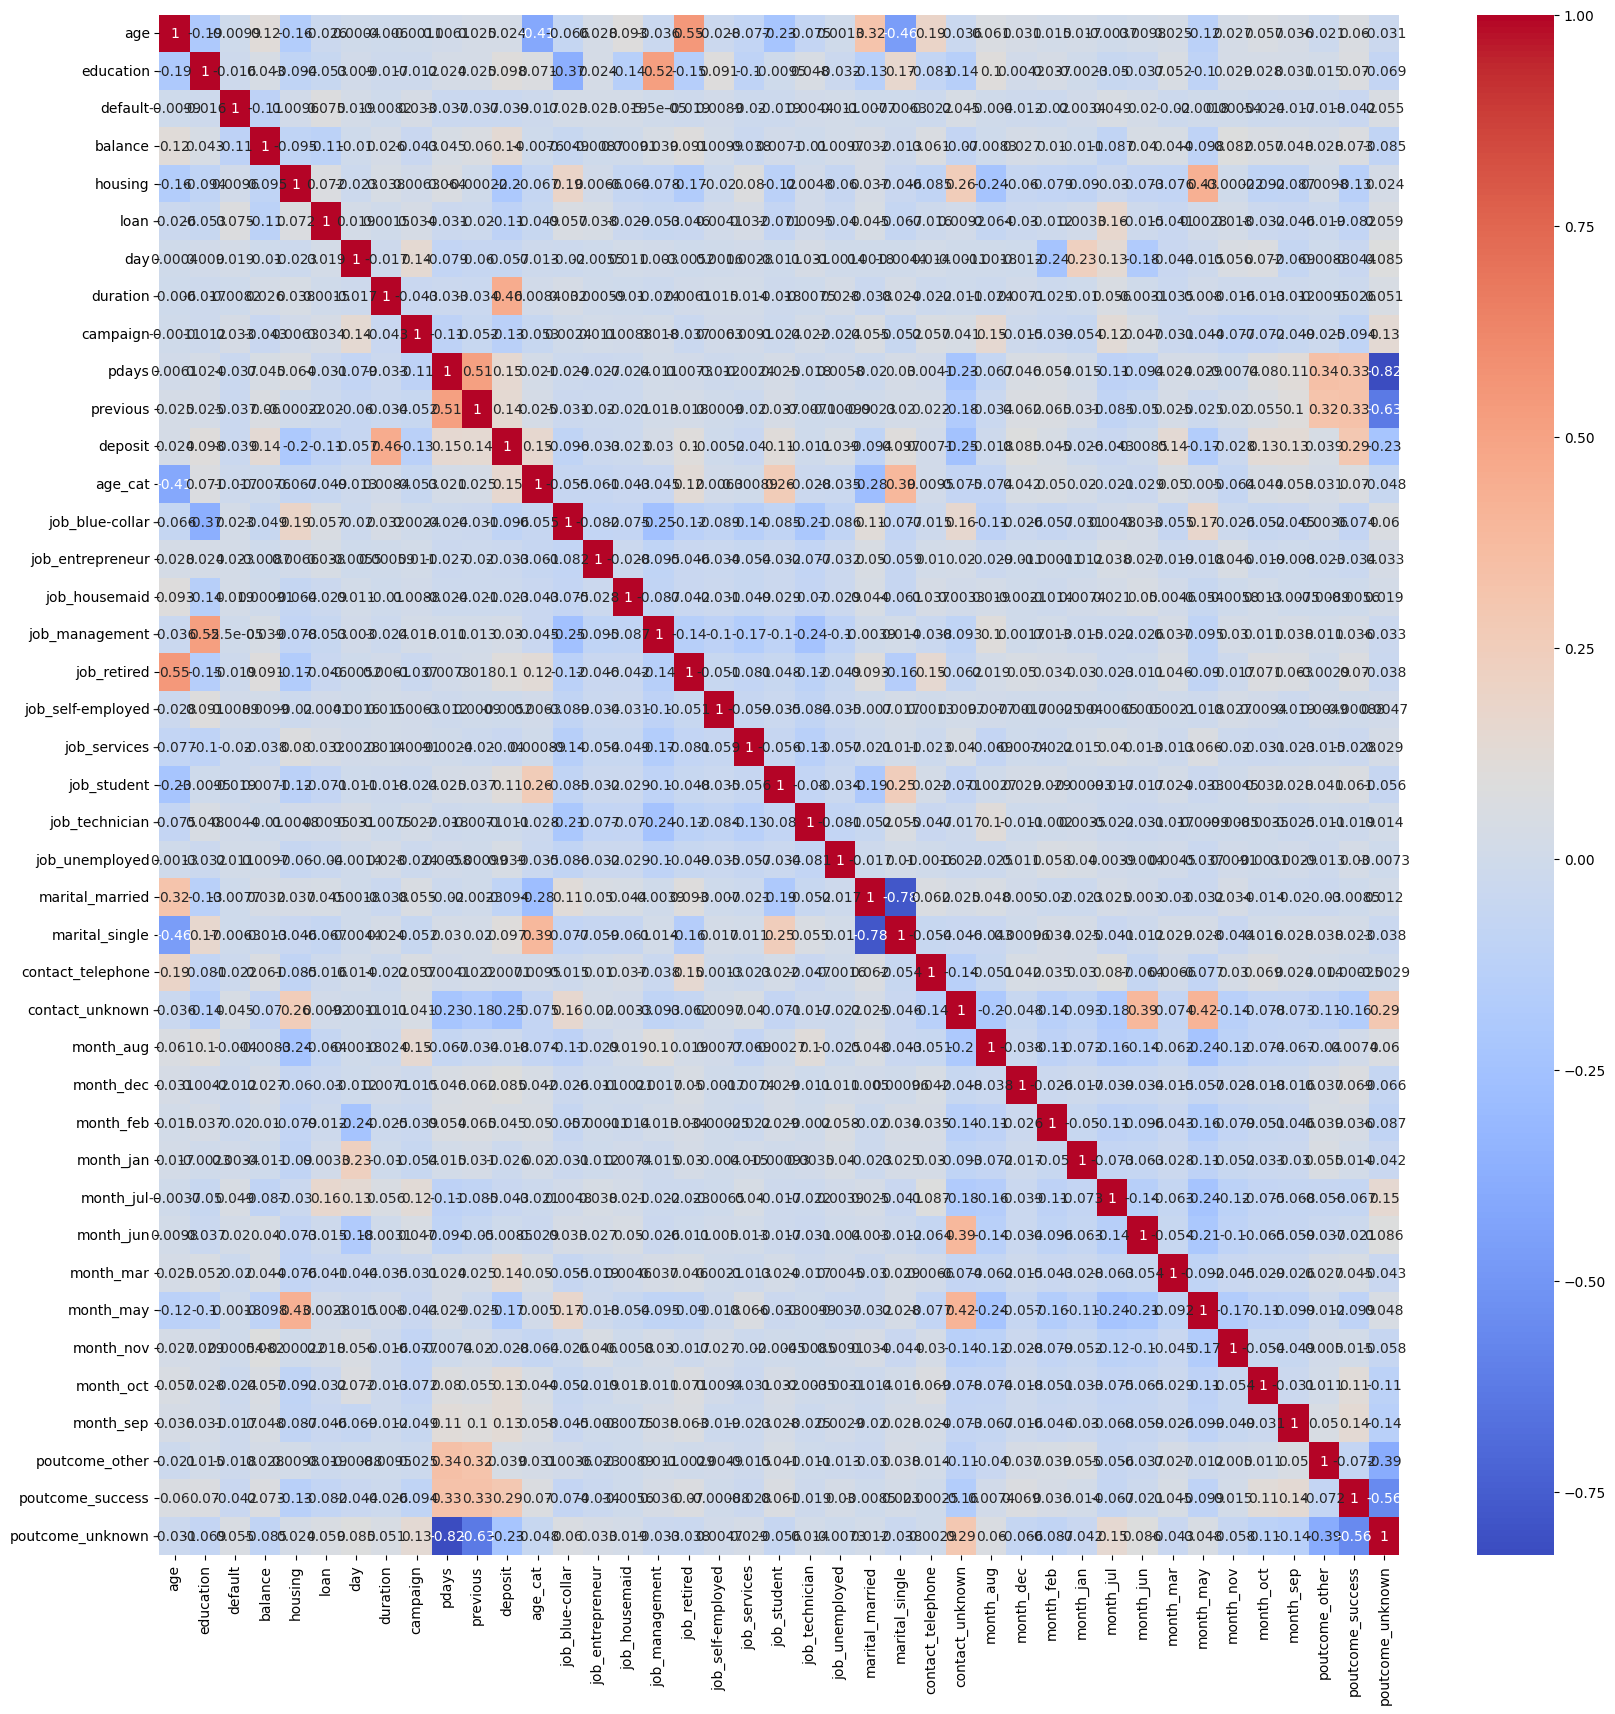

In [299]:
# оценим мультиколлинеарность признаков
corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm')



<AxesSubplot: >

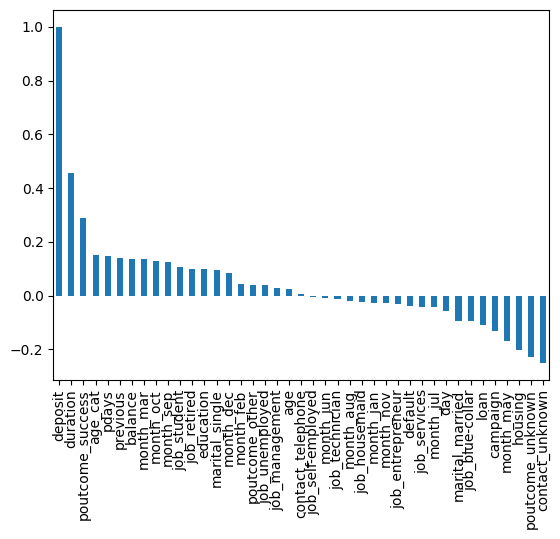

In [300]:
# построим столбчатую диаграмму, для ранжирования признаков корреляции с целевой переменной
corr['deposit'].sort_values(ascending=False).plot(kind='bar')


In [326]:
# разделим данные на обучающую и тестовую выборки. Размер тестовой выборки - 33%. Зафиксируем random_state=42. Сохраним соотношение классов целевой переменной в обучающей и тестовой выборках.
#X = df.drop('deposit', axis=1)
#y = df['deposit']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=df['deposit'])


In [328]:
#X_test.shape

(3335, 40)

In [302]:
# нормализуем данные с помощью MinMaxScaler
#scaler = preprocessing.MinMaxScaler()
#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)


In [303]:
#round(X_test[1].mean(),2)

In [304]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

### Задание 5

In [305]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

### Задание 6

In [306]:
# удалите все выбросы для признака balance
# ваш код

## Часть 2:  Разведывательный анализ

### Задание 1

In [307]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

### Задания 2 и 3

In [308]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

### Задания 4 и 5

In [309]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

### Задание 6

In [310]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

### Задание 7

In [311]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

### Задание 8

In [312]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

### Задания 9 и 10

In [313]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [314]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [315]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [316]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [317]:
# преобразуйте уровни образования

### Задания 2 и 3

In [318]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [319]:
# создайте дамми-переменные

### Задания 5 и 6

In [320]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [330]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [331]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 40)

### Задание 9

In [332]:
# с помощью SelectKBest отберем 15 лучших признаков, используя f_classif
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
X_train.columns[selector.get_support()]


Index(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'age_cat', 'contact_unknown', 'month_mar', 'month_may',
       'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [333]:
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

### Задание 10

In [334]:
# нормализуем данные с помощью MinMaxScaler для предикторов
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



In [339]:
# рассчитаем среднее арифметическое для первого признака в обучающей выборке
round(X_train[:,0].mean(),2)


0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [340]:
# обучите логистическую регрессию и рассчитайте метрики качества, алгоритм 'sag' и random_state=42, количество итераций установите равным 1000
# ваш код
lr = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
metrics.accuracy_score(y_test, y_pred)


0.8107946026986507

### Задания 2,3,4

In [354]:
# обучите решающие деревья, criterion = 'entropy', random_state = 42
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
dt.fit(X_train, y_train)
y_test_pred = dt.predict(X_test)
y_train_pred = dt.predict(X_train)

print (round(metrics.accuracy_score(y_test, y_test_pred),2))

print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

# 0.7409295352323838

0.81
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.78      0.85      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [365]:
# подберите оптимальные параметры с помощью gridsearch, используйте параметры 'max_depth', 'min_samples_split', 'min_samples_leaf'
# ваш код
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [3,5,7],
              'min_samples_split': [2,5,7,10],
              #'min_samples_leaf': range(1, 10)
              }

grid_search_cv_clf = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), parameters, scoring='f1')
grid_search_cv_clf = grid_search_cv_clf.fit(X_train, y_train)
best_clf = grid_search_cv_clf.best_estimator_
best_clf



DecisionTreeClassifier(max_depth=7, min_samples_split=10, random_state=42)

In [367]:
# оценим метрику F1 для полученной модели
y_test_pred = best_clf.predict(X_test)
y_train_pred = best_clf.predict(X_train)

print(metrics.f1_score(y_test, y_test_pred))
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))


0.7989623865110247
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3634
           1       0.83      0.81      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.80      0.80      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [369]:
# обучите на ваших данных случайный лес, random_state = 42
# ваш код
rf = ensemble.RandomForestClassifier(random_state=42,
                                    n_estimators=100,
                                    max_depth=10,
                                    min_samples_leaf=5,
                                    min_samples_split=5,
                                    criterion='gini',
                                    )

rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

print(metrics.f1_score(y_test, y_test_pred))
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

0.8191320874247704
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      3634
           1       0.84      0.87      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [370]:
# используйте для классификации градиентный бустинг, random_state = 42
# ваш код
gb = ensemble.GradientBoostingClassifier(random_state=42,
                                        learning_rate=0.05,
                                        n_estimators=300,
                                        max_depth=5,
                                        min_samples_leaf=5,                                        
                                        #criterion='mse',
                                        )

gb.fit(X_train, y_train)
y_test_pred = gb.predict(X_test)
y_train_pred = gb.predict(X_train)

print(metrics.f1_score(y_test, y_test_pred))
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))




0.8162746344564525
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [372]:
# объедините уже известные вам алгоритмы с помощью стекинга, в качестве метамодели используйте логистическую регрессию
# ваш код
from sklearn.ensemble import StackingClassifier

lr_final = linear_model.LogisticRegression(
                                        #solver='sag',
                                        random_state=42,
                                        #max_iter=1000
                                        )

estimators = [('lr', lr), ('gb', gb), ('dt', dt)]
clf = StackingClassifier(estimators=estimators, final_estimator=lr_final)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print(metrics.f1_score(y_test, y_test_pred))
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))


0.8117533096545043
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3634
           1       0.85      0.85      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna